In [ ]:
!pip install -q pyomo --quiet
!apt-get install -y -qq glpk-utils --quiet

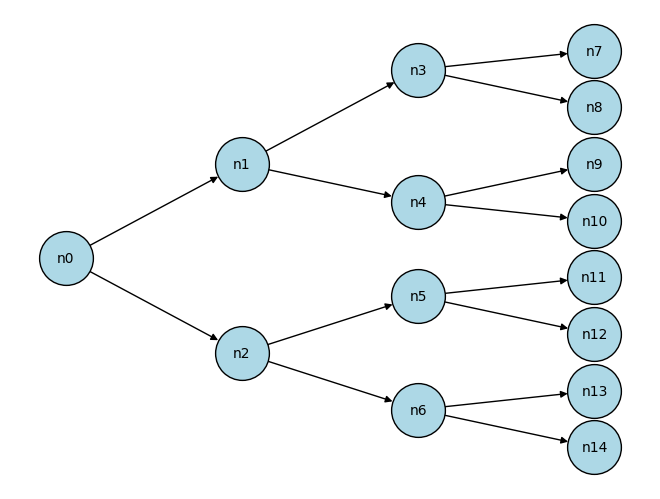

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges according to the corrected order
edges = [
    # From t=0 to t=1
    ('n0', 'n1'),
    ('n0', 'n2'),
    # From t=1 to t=2
    ('n1', 'n3'),
    ('n1', 'n4'),
    ('n2', 'n5'),
    ('n2', 'n6'),
    # From t=2 to t=3
    ('n3', 'n7'),
    ('n3', 'n8'),
    ('n4', 'n9'),
    ('n4', 'n10'),
    ('n5', 'n11'),
    ('n5', 'n12'),
    ('n6', 'n13'),
    ('n6', 'n14')
]
# Add edges to the graph
G.add_edges_from(edges)

# Define a layout for our nodes
layout = {
    'n0': (0, -5),
    'n1': (1, 20), 'n2': (1, -30),
    'n3': (2, 45), 'n4': (2, 10), 'n5': (2, -15), 'n6': (2, -45),
    'n7': (3, 50), 'n8': (3, 35), 'n9': (3, 20), 'n10': (3, 5), 'n11': (3, -10), 'n12': (3, -25), 'n13': (3, -40), 'n14': (3, -55)
}
# Draw the graph using the custom layout
nx.draw(G, pos=layout, with_labels=True, node_size=1500, node_color='lightblue', edgecolors='black', font_size=10)

# Show the plot
plt.show()

In [4]:
from pyomo.environ import *
import numpy as np

# Define the model
model = ConcreteModel('Multi-Stage ALM Compact Model')

# Sets
model.I  = Set(initialize=['stocks', 'bonds'])
Nodes  = [f'n{i}' for i in range(15)]
Routes = [f'n{i}' for i in range(7) for _ in range(2)]
model.N  = Set(initialize=Nodes)
model.S  = Set(initialize=Nodes[7:])
model.T  = Set(initialize=Nodes[1:7])
model.M  = Set(initialize=Nodes[:7])

# Parameters
prob = np.array([1/len(model.S)]*len(model.S))
model_R_data = {'stocks': [1.25 if i % 2 == 0 else 1.06 for i in range(14)],
                'bonds': [1.14 if i % 2 == 0 else 1.12 for i in range(14)]}

model.R = Param(model.I, model.N, initialize={
    **{('stocks', f'n{i+1}'): model_R_data['stocks'][i] for i in range(len(model_R_data['stocks']))},
    **{('bonds', f'n{i+1}'): model_R_data['bonds'][i] for i in range(len(model_R_data['bonds']))}
})
model.q  = Param(initialize=1)
model.r  = Param(initialize=1)
model.pr = Param(model.S,initialize={i: prob[j] for i in model.S for j in range(len(prob))},within=Any)
model.W0 = Param(initialize=55000)
model.L  = Param(initialize=80000)

func_a = dict(zip(Nodes[1:], Routes))
def previous_node(node):
    previous_nodes = func_a
    return previous_nodes.get(node)

# Variables
model.x = Var(model.I, model.M, domain=NonNegativeReals)
model.w_plus = Var(model.S, domain=NonNegativeReals)
model.w_minus = Var(model.S, domain=NonNegativeReals)

# Objective function
def obj_rule(model):
    return quicksum(model.pr[s] * (model.q * model.w_plus[s] - model.r * model.w_minus[s]) for s in model.S)
model.obj = Objective(rule=obj_rule, sense=maximize)

# Constraints
def budget_constraint_rule(model):
    return quicksum(model.x[i, 'n0'] for i in model.I) == model.W0
model.budget_constraint = Constraint(rule=budget_constraint_rule)

def return_investment_constraint_rule(model, n):
    if n in model.T:
        return quicksum(model.R[i, n] * model.x[i, previous_node(n)] for i in model.I) == quicksum(model.x[i, n] for i in model.I)
    else:
        return Constraint.Skip
model.return_investment_constraint = Constraint(model.T, rule=return_investment_constraint_rule)

def return_liability_constraint_rule(model, s):
    if s in model.S:
        return quicksum(model.R[i, s] * model.x[i, previous_node(s)] for i in model.I) == model.L + model.w_plus[s] - model.w_minus[s]
    else:
        return Constraint.Skip
model.return_liability_constraint = Constraint(model.S, rule=return_liability_constraint_rule)

# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)

# Display results
# results.write()
# model.display()
for i in model.I:
    for m in model.M:
            if value(model.x[i,m]) != 0:
                print(f"x[{i}, {m}] =", round(value(model.x[i, m]),2))
print(round(value(model.obj),2))


x[stocks, n0] = 55000.0
x[stocks, n1] = 68750.0
x[stocks, n2] = 58300.0
x[stocks, n3] = 85937.5
x[stocks, n4] = 72875.0
x[stocks, n5] = 72875.0
x[stocks, n6] = 61798.0
4743.94
